In [13]:
import numpy as np
import sklearn
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

In [15]:
if not os.path.exists('Rep 4'):
    # Create the directory
    os.makedirs('Rep 4')

In [20]:
test_data_file_path = 'Copy of Test values.xlsx'
test_data = pd.ExcelFile(test_data_file_path)

sheet_names = test_data.sheet_names
print(*sheet_names, sep='\n')

PumpV with Flow rate
Rubber tube flow testing
12V pump-3 fan - temp testing
7V pump-3 fan- temp testing
3.5V pump-3 fan- temp testing
3.5V pump-no fan-temp testing
12V pump-no fan-temp testing
7.5V pump-no fan- temp testing
12V pump - 1 fan - temp testin 
7V pump-1 fan-tem testing
3.5V-1 fan-temp testing
12V pump-2 fan-temp testing
7V pump-2 fan-temp testing
3.5V pump-2 fan-temp testing
12V pump-chiller-temp testing
7V pump-chiller-temp testing
3.5V pump-chiller-temp testing
Heater-Radiator-3.5V
Heater-Radiator-7V
Heater-Radiator-12V
Heater-Radiator-9.2V


In [5]:
pump_0_id = 'pump-no'
pump_1_id = '-1'
pump_2_id = 'pump-2'
pump_3_id = 'pump-3'
pump_chill_id = 'pump-chiller'

In [6]:
def data_extraction(excel_sheet):
    """
    This function converts the information of one excel sheet.

    Paramters functionalities:

    header = 0 := means that in the sheet the first row will be 
    consider as the headers of the dataframe.

    usecols = range(3) := means that you are going to use only the first 3 columns
    in case you need to use from column 3 to 6 the range function should be used as 
    range(3,6)
    
    """
    data = pd.read_excel(test_data_file_path, excel_sheet, header=0, usecols=range(3))
    return data.ffill()

### 2 fan Analysis

In [8]:
volts = [3.5, 7, 12]
time = ''

def excel_sheet_spec(sheet_id):
    data = {}
    for volt in volts:
        for excel_sheet in sheet_names:
            if f'{volt}' in excel_sheet and sheet_id in excel_sheet.replace(" ", ""):
                data[volt] = data_extraction(excel_sheet)
    return data

In [9]:
pump_2_data = excel_sheet_spec(pump_2_id)
time = pump_2_data[3.5].columns[0]
temp = pump_2_data[3.5].columns[1]

In [10]:
def exp_inverse(t, k, T0, Ta):    
    a = (T0 - Ta)
    c = Ta
    return a*np.exp(-k*t/1000) + c

In [11]:
def all_data_points(data):
    for volt in volts:
        time_data = data[volt][time]
        temp_data = data[volt][temp]
        plt.scatter(time_data, temp_data, label = f'{volt} V')
        
    plt.legend()
    plt.show()

In [12]:
from scipy.optimize import curve_fit

def k_plot_values(data, volts, set_up):
    k_values = []
    T0_values = []
    Ta_values = []
    
    for volt in volts:
        
        time_data = data[volt][time]
        temp_data = data[volt][temp]
        
        popt, _ = curve_fit(exp_inverse, time_data, temp_data, maxfev=10000)
    
        k_values.append(popt[0]/1000)
        T0_values.append(popt[1])
        Ta_values.append(popt[2])
        
    #return k_values, T0_values, Ta_values

    
    plt.scatter(volts, k_values, color = 'red')
    plt.xlabel('Volts')
    plt.ylabel('Kappas')
    plt.title(f'K points for {set_up} fans' if set_up != 1 else f'K points for {set_up} fan')
    plt.savefig(f'REP 4/k_points_{set_up}_fans.png' 
                if set_up != 1 else f'Rep 4/k_points_{set_up}_fan.png')
    plt.show()
    return k_values, T0_values, Ta_values

In [13]:
colors_d = ['blue', 'orange', 'green']
colors_f = ['c', 'm', 'y']

def data_vs_fitted(data, ks, T0s, Tas, set_up):
    for k, T0, Ta , volt, color_d, color_f in zip(ks, T0s, Tas, volts, colors_d, colors_f):
        pred = exp_inverse(data[volt][time], 1000*k, T0, Ta)
        plt.scatter(data[volt][time], data[volt][temp], color=color_d, label = f'{volt}V data', alpha=.2)
        plt.plot(data[volt][time], pred, color = color_f, label = f'{volt}V fitted')
    plt.title(f'Data vs Fitted ({set_up} Fans)' if set_up != 1 else f'Data vs Fitted ({set_up} Fan)')
    plt.legend()
    plt.savefig(f'Rep 4/data_vs_fitted_{set_up}_fans.png' 
                if set_up != 1 else f'Rep 4/data_vs_fitted_{set_up}_fan.png')
    plt.show()

In [14]:
def quadratic(x, a, b, c):
    return a* x**2 + b*x + c

def voltage_prediction(k_values, set_up):
    x = np.array(volts)
    y = np.array(k_values)
    
    
    popt, cov = curve_fit(quadratic, x, y)
    
    x_pred = np.arange(3.5, 12.1, .1)
    pred = quadratic(x_pred, *popt)
    
    plt.scatter(x, y, label="Experimental K's", color='red')
    plt.plot(x_pred, pred, label="Predicted K's", linestyle='--', color='blue')
    
    index = np.where(pred==max(pred))
    plt.axvline(x=x_pred[index], color='black', linestyle='--', 
                label=f'Best K: {max(pred):.4f} at {x_pred[index][0]:.1f}V')
    
    plt.xlabel('Volts')
    plt.ylabel("Kappa's")
    plt.legend(loc='center left')
    plt.title(f'Predicted K(V) for {set_up} fans' if set_up != 1 else f'Predicted K(V) for {set_up} fan')
    plt.savefig(f'Rep 4/ks_predicted_by_voltage_{set_up}_fan.png')
    plt.show()

In [15]:
# Function to calculate T of function of V at 60 min

def Temp_at_t_60_function_voltage(ks, T0s, Tas, set_up, t=60):
    voltages = np.arange(3.5, 12.1, .1)
    popt, _ = curve_fit(quadratic, volts, ks)
    k_pred = quadratic(voltages, *popt)
    # Calculate mean for T0 and Ta

    T0_mean = np.mean(T0s)
    Ta_mean = np.mean(Tas)
    
    # Calculate temperatures

    T_60_min = exp_inverse(t, 1000*k_pred, T0_mean, Ta_mean)
    
    #plt.plot(voltages, k_pred)
    plt.plot(voltages, T_60_min, color='blue')
    plt.xlabel('Voltage')
    plt.ylabel('Temperature (Celsius)')
    plt.title(f'Temperature vs Voltage after 60 min for {set_up} Fans' if set_up != 1 else f'Temperature vs Voltage after 60 min for {set_up} Fan')
    index = np.where(T_60_min==min(T_60_min))
    plt.scatter(voltages[index], min(T_60_min),color='red',
                label=f'Coolest Temperature: {min(T_60_min):.1f}\u00b0C at {voltages[index][0]:.1f}V')
    plt.legend()
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig(f'Rep 4/temperature_vs_voltage_after_t_60_{set_up}_fan.png')
    plt.show()
    

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator


def plot_3d(T0s, Tas, ks, set_up):

    # Define the function
    def f(t, v, T0, Ta, a, b, c):
        k = a*v**2 + b*v + c
        return (T0-Ta)*np.exp(-k*t) + Ta
    
    # Create coordinate matrices from coordinate vectors
    y = np.arange(3.5, 12.1, .1)
    
    x = np.linspace(0, 60, len(y))
    
    x, y = np.meshgrid(x, y)
    
    T0_mean = np.mean(T0s)
    Ta_mean = np.mean(Tas)
    
    k_values = np.array(ks)
    v_values = np.array(volts)
    
    
    popt, _ = curve_fit(quadratic, v_values, k_values)
    
    # Compute Z (height) as a function of X and Y
    z = f(x, y, T0_mean, Ta_mean, *popt)

    # Lowest Z at each X
    min_Z = np.min(z, axis=0)
    min_Y = y[np.argmin(z, axis=0), range(z.shape[1])]

    
    # Create a figure
    fig = plt.figure(figsize=(6, 6))
    # Specify 3D plot
    ax = plt.axes(projection='3d')
    #ax = fig.add_subplot(111, projection='3d')
    
    # Specify 3D plot
    
    # Plot the surface
    colors = plt.cm.viridis(y / 12) # Using the y-axis to define the color gradient
    ax.plot_surface(x, y, z, facecolors=colors, linewidth=0)

    # Highlight the lowest Z values with a red line
    ax.plot(x[0], min_Y, min_Z, color='red', linewidth=3, 
            label=f'Lowest Achievable Temperature')

    
    
    # Add labels
    ax.set_xlabel('Time')
    #ax.set_ylabel('Voltage')
    ax.set_zlabel('Temperature')
    
    # Set title
    ax.set_title(f'Lowest Achievable Temperature for {set_up} fans' 
                 if set_up != 1 else f'Lowest Achievable Temperature for {set_up} fan')
    
    # Point of view
    ax.view_init(0, -90)
    #ax.set_zlim([31,31.7])
    
    ax.legend()

    # Remove y-axis numbers
    ax.set_yticklabels([])
    
    #ax.zaxis.set_major_locator(MaxNLocator(integer=True))

    plt.savefig(f'Rep 4/minimum_achievable_temp_{set_up}_fans.png' 
                if set_up != 1 else f'Rep 4/minimum_achievable_temp_{set_up}_fan.png' )
    # Show the plot
    plt.show()
    return min_Y
    # plot Voltage for the lowest achievable temperature

    #plt.plot(np.linspace(0, 60, len(min_Y)), min_Y)
#plot_3d(T0s, Tas, ks, 0)

In [17]:
from mpl_toolkits.mplot3d import Axes3D

def normal_plot_3d(T0s, Tas, ks, set_up):

    # Define the function
    def f(t, v, T0, Ta, a, b, c):
        k = a*v**2 + b*v + c
        return (T0-Ta)*np.exp(-k*t) + Ta
    
    # Create coordinate matrices from coordinate vectors
    y = np.arange(3.5, 12.1, .1)
    
    x = np.linspace(0, 60, len(y))
    
    x, y = np.meshgrid(x, y)
    
    T0_mean = np.mean(T0s)
    Ta_mean = np.mean(Tas)
    
    k_values = np.array(ks)
    v_values = np.array(volts)
    
    
    popt, _ = curve_fit(quadratic, v_values, k_values)
    
    # Compute Z (height) as a function of X and Y
    z = f(x, y, T0_mean, Ta_mean, *popt)

    # Lowest Z at each X
    min_Z = np.min(z, axis=0)
    min_Y = y[np.argmin(z, axis=0), range(z.shape[1])]

    
    # Create a figure
    fig = plt.figure(figsize=(5, 5))
    # Specify 3D plot
    #ax = plt.axes(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    colors = plt.cm.viridis(y / 12) # Using the y-axis to define the color gradient
    ax.plot_surface(x, y, z, facecolors=colors, linewidth=0, alpha=.5)
    
    # Highlight the lowest Z values with a red line
    ax.plot(x[0][1:], min_Y[1:], min_Z[1:], color='red', linewidth=3, 
            label=f'Lowest Achievable Temperature')

    
    
    # Add labels
    #ax.set_xlabel('Time')
    ax.set_ylabel('Voltage')
    ax.set_zlabel('Temperature', labelpad=-2)
    
    # Set title
    ax.set_title(f'3D Plot of the function T(t, V) for {set_up} fans' 
                 if set_up != 1 else f'3D Plot of the function T(t, V) for {set_up} fan')
    
    # Point of view
    ax.view_init(0, 0)
    #ax.set_zlim([31,31.7])
    
    ax.legend()

    # Remove y-axis numbers
    #ax.set_yticklabels([])

    # Adjust layout to ensure labels are visible
    ax.zaxis.label.set_position((0.5, -0.5))
    ax.zaxis.set_major_locator(MaxNLocator(integer=True))

    # Remove y-axis numbers
    ax.set_xticklabels([])
    plt.tight_layout()

    #fig.subplots_adjust(left=0.2, right=.8, top=0.8, bottom=0.2)
    plt.savefig(f'Rep 4/normal_3d_plot_{set_up}_fans.png' 
                if set_up != 1 else f'Rep 4/normal_3d_plot_{set_up}_fan.png' )
    # Show the plot
    plt.show()
    # plot Voltage for the lowest achievable temperature
    #return min_Y
    #plt.plot(np.linspace(0, 60, len(min_Y)), min_Y)
#normal_plot_3d(T0s, Tas, ks, 0)

### 0 Fan data

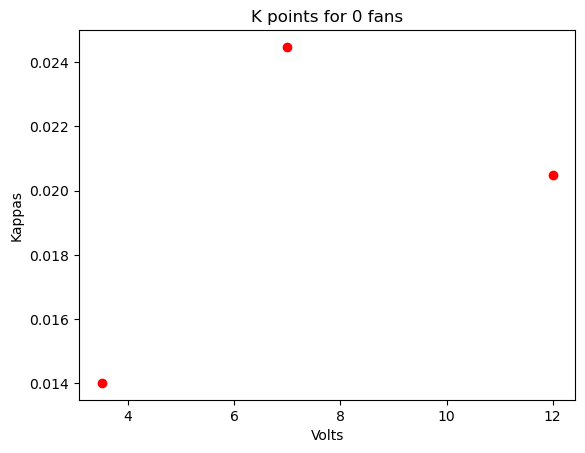

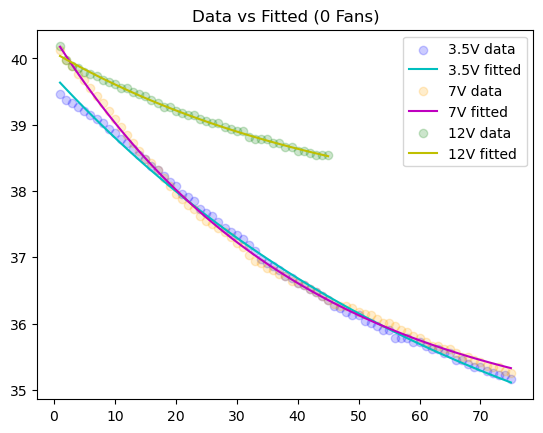

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2641540925.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, cov = curve_fit(quadratic, x, y)


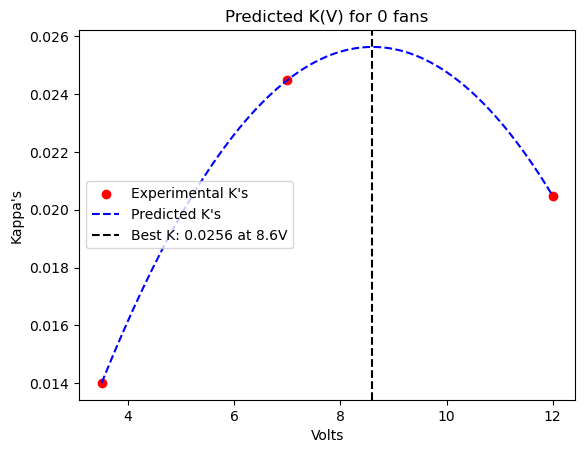

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2591348910.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, volts, ks)


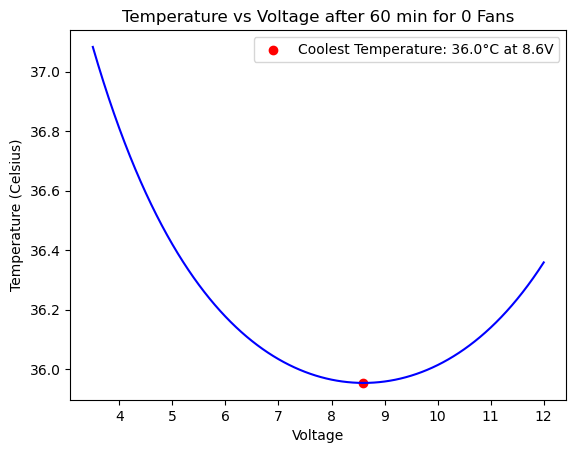

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2612079881.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)


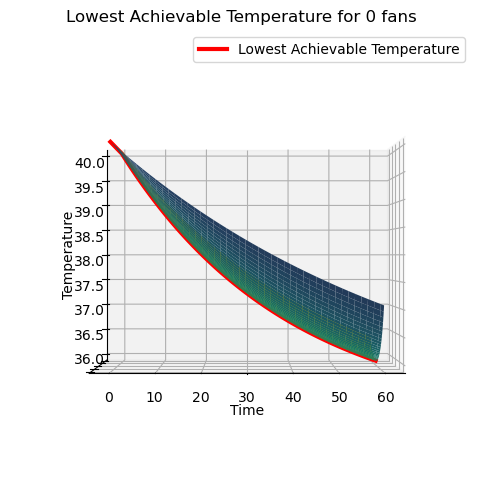

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)
C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


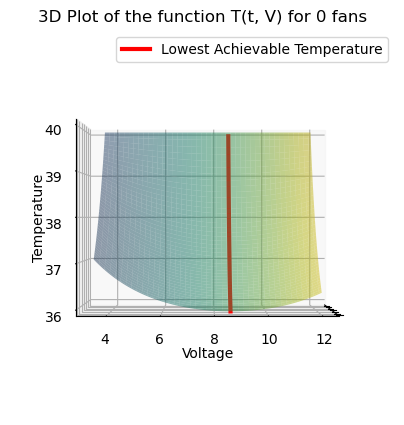

In [19]:
pump_0_data = excel_sheet_spec(pump_0_id)

# plot all datapoints
#all_data_points(pump_0_data)

ks, T0s, Tas = k_plot_values(pump_0_data, volts, 0)

data_vs_fitted(pump_0_data, ks, T0s, Tas, 0)

voltage_prediction(ks, 0)

Temp_at_t_60_function_voltage(ks, T0s, Tas, 0)

plot_3d(T0s, Tas, ks, 0)

normal_plot_3d(T0s, Tas, ks, 0)

### 1 Fan data

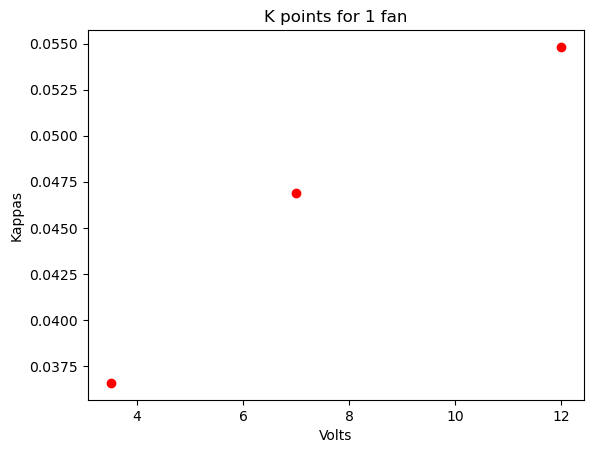

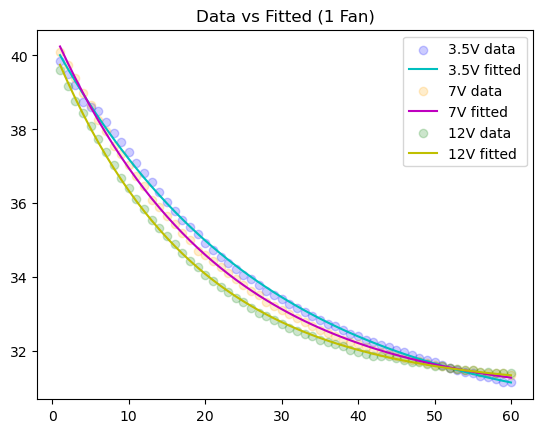

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2641540925.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, cov = curve_fit(quadratic, x, y)


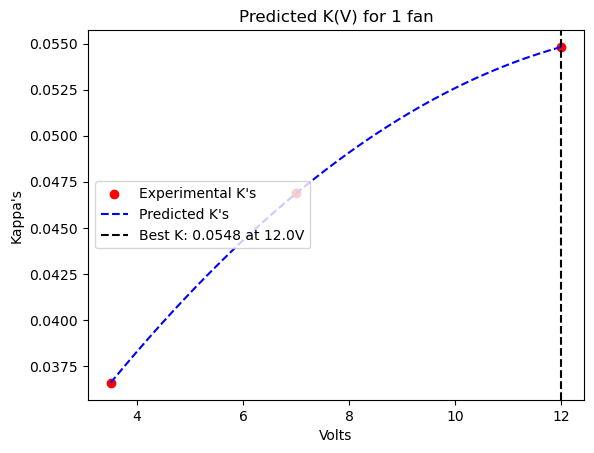

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2591348910.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, volts, ks)


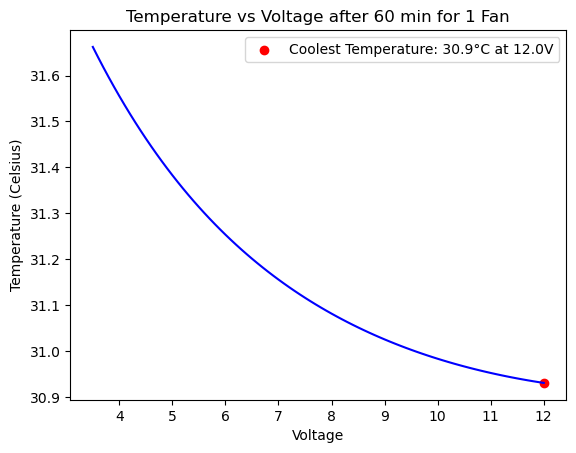

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2612079881.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)


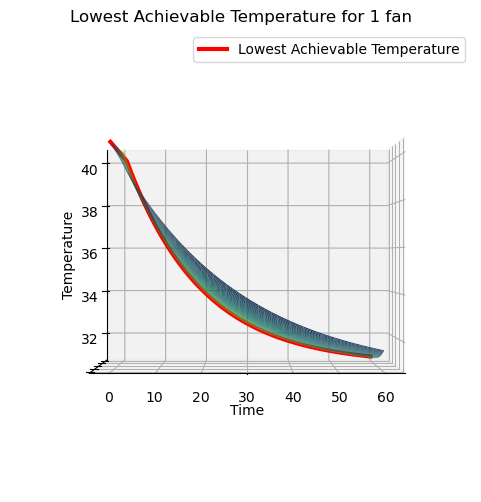

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)
C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


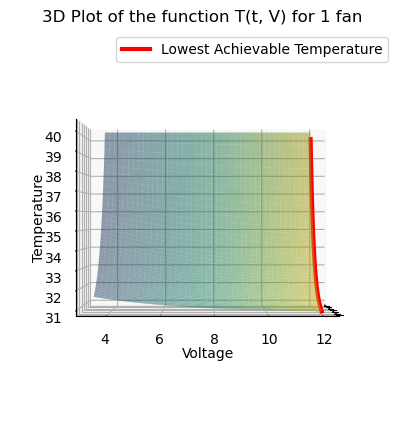

In [21]:
pump_1_data = excel_sheet_spec(pump_1_id)

#all_data_points(pump_1_data)

ks, T0s, Tas = k_plot_values(pump_1_data, volts, 1)

data_vs_fitted(pump_1_data, ks, T0s, Tas, 1)

voltage_prediction(ks, 1)

Temp_at_t_60_function_voltage(ks, T0s, Tas, 1)

plot_3d(T0s, Tas, ks, 1)

normal_plot_3d(T0s, Tas, ks, 1)

### 2 Fan data

### Calculate the temperature at every voltage at 60 min

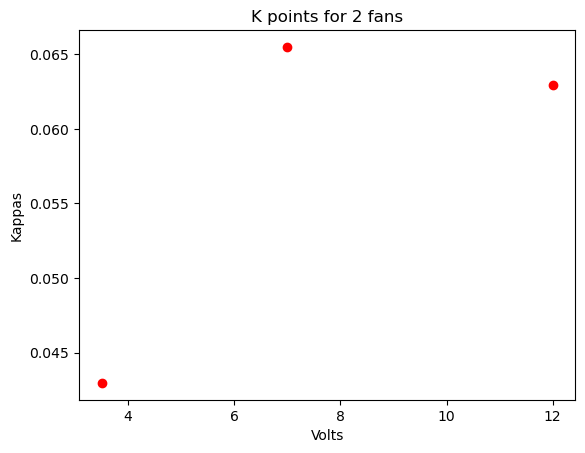

[0.042979187076093245, 0.06548992591215562, 0.06294534512772634]


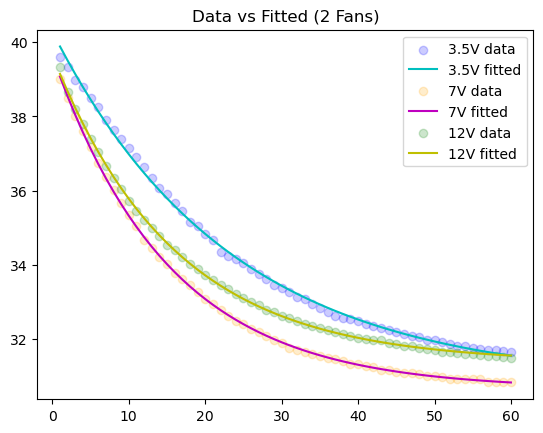

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2641540925.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, cov = curve_fit(quadratic, x, y)


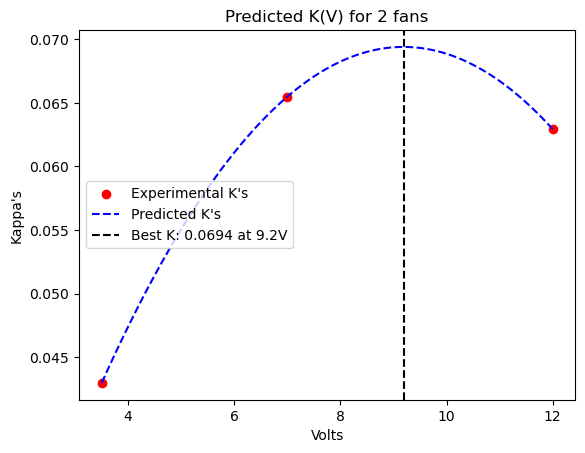

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2591348910.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, volts, ks)


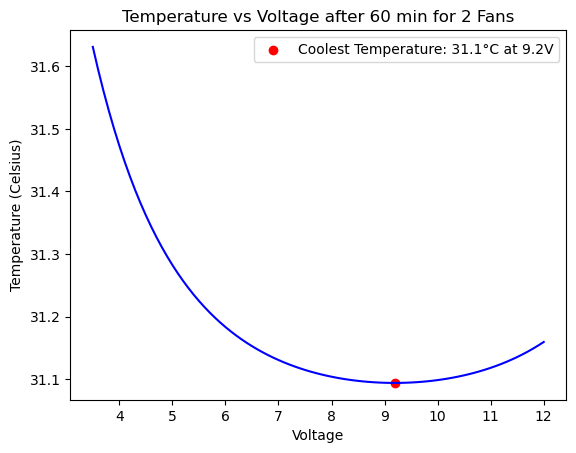

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2612079881.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)


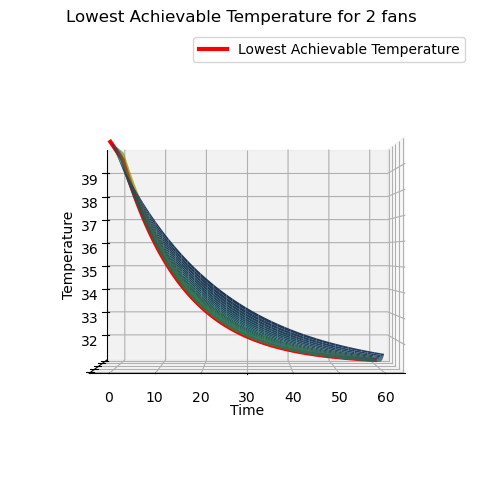

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)
C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


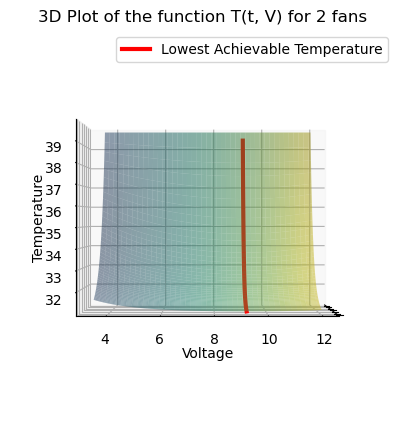

In [24]:
pump_2_data = excel_sheet_spec(pump_2_id)

#all_data_points(pump_2_data)

ks, T0s, Tas = k_plot_values(pump_2_data, volts, 2)
print(ks)
data_vs_fitted(pump_2_data, ks, T0s, Tas, 2)

voltage_prediction(ks, 2)

Temp_at_t_60_function_voltage(ks, T0s, Tas, 2)

plot_3d(T0s, Tas, ks, 2)

normal_plot_3d(T0s, Tas, ks, 2)

### 3 fan data

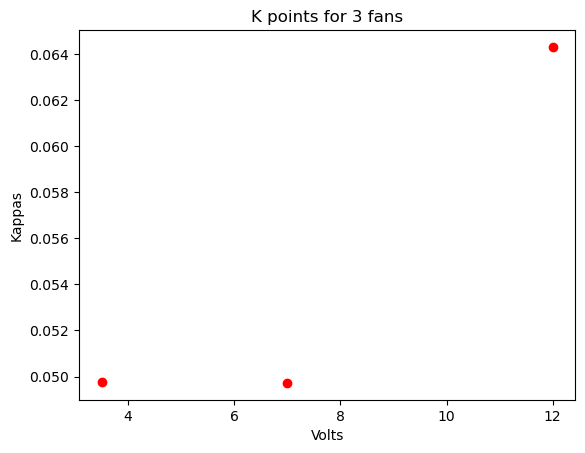

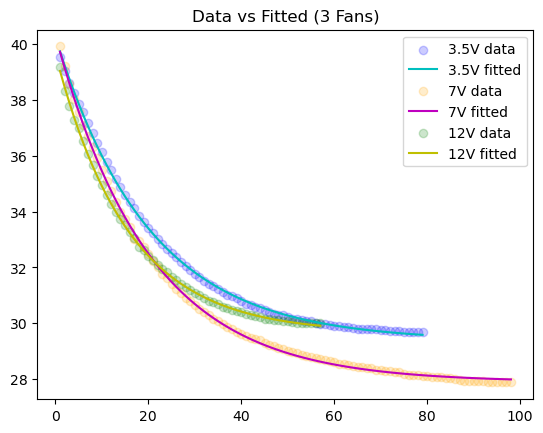

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2641540925.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, cov = curve_fit(quadratic, x, y)


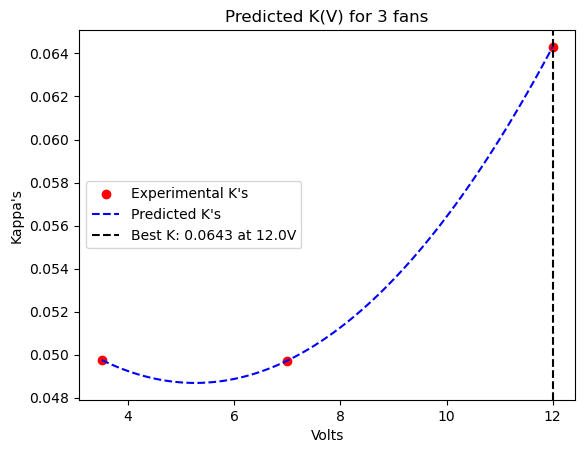

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2591348910.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, volts, ks)


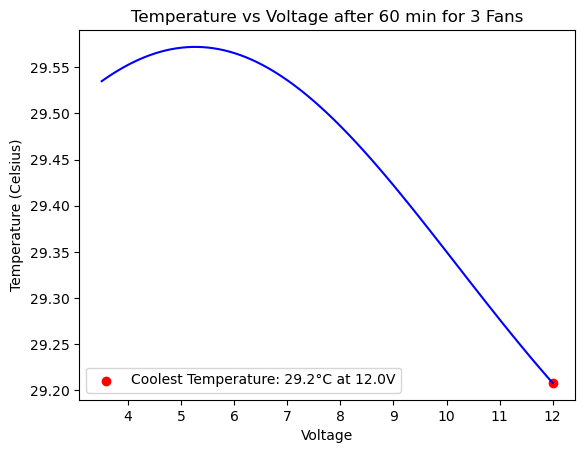

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2612079881.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)


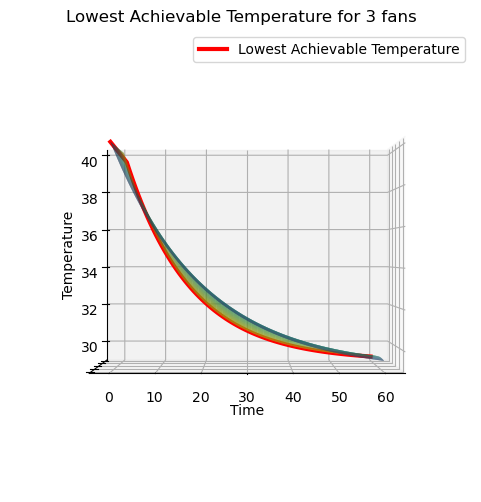

C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, v_values, k_values)
C:\Users\super\AppData\Local\Temp\ipykernel_21660\2857137050.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


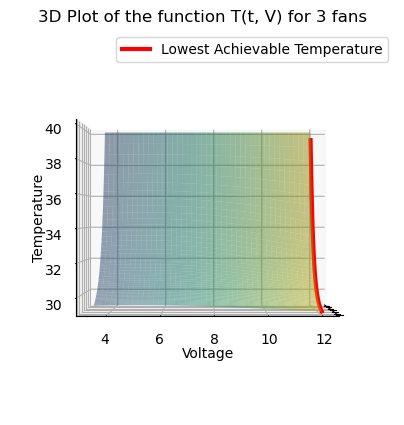

In [26]:
pump_3_data = excel_sheet_spec(pump_3_id)

#all_data_points(pump_3_data)


ks, T0s, Tas = k_plot_values(pump_3_data, volts, 3)

data_vs_fitted(pump_3_data, ks, T0s, Tas, 3)

voltage_prediction(ks , 3)

Temp_at_t_60_function_voltage(ks, T0s, Tas, 3)

plot_3d(T0s, Tas, ks, 3)

normal_plot_3d(T0s, Tas, ks, 3)

### 3D Plot 

### Move chiller data to the right so they can be compared at the same T0

In [29]:
rad_only = excel_sheet_spec(pump_3_id)
chiller = excel_sheet_spec(pump_chill_id)

### add the time passed from 0 to the first value from rad_only that is under
### the first value of the temperature from chiller

fix_x_chiller = {}
set_points = {}
times_passed = {}

for volt in volts:
    set_point = chiller[volt][temp].iloc[0]
    set_points[volt] = set_point
    time_passed = rad_only[volt][rad_only[volt][temp] < set_point].idxmax()
    times_passed[volt] = time_passed.iloc[1]
    fix_x_chiller[volt] = chiller[volt].copy()
    fix_x_chiller[volt][time] = fix_x_chiller[volt][time] + time_passed.iloc[1]

new_chiller = fix_x_chiller

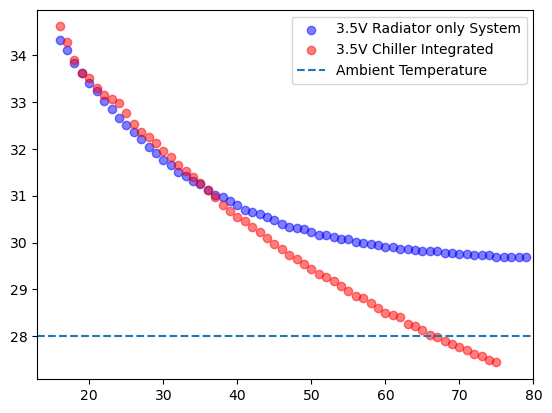

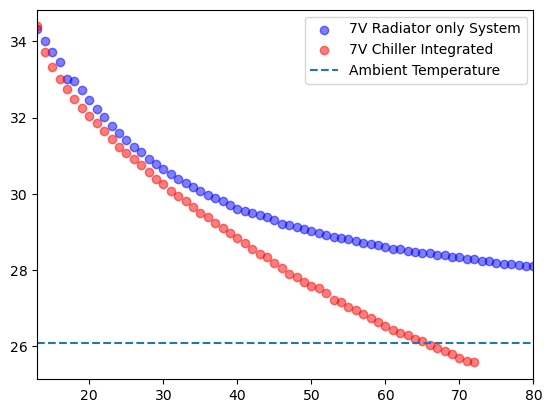

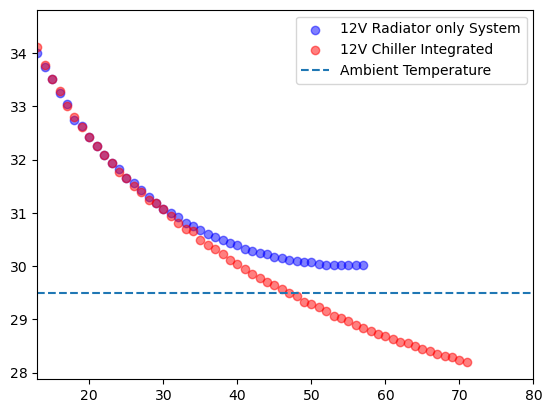

In [30]:
# save differences in temperature

lens = {}
new_rad = {}

Tas_data = [28,26.1,29.5]

for volt, Ta in zip(volts[:],Tas_data[:]): 
    #volt = 7
    new_rad[volt] = rad_only[volt][rad_only[volt][time]>times_passed[volt]].reset_index(drop=True)
    
    x_r = new_rad[volt][time] 
    y_r = new_rad[volt][temp]
    
    x_c = new_chiller[volt][time]
    y_c = new_chiller[volt][temp]

    lens[volt] = len(x_r)
    
    plt.scatter(x_r, y_r, label=f'{volt}V Radiator only System', color='blue', alpha=.5)
    plt.scatter(x_c, y_c, label=f'{volt}V Chiller Integrated', color='red', alpha=.5)

    plt.xlim(13, 80)
    plt.axhline(y=Ta, linestyle='--', label='Ambient Temperature')
    plt.legend()
    plt.show()

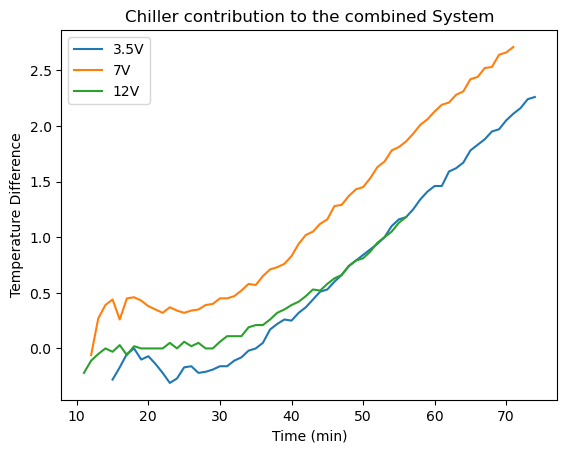

In [31]:
# Calculate diff in temp

temp_diff = {}

for volt in volts[:]:
    temp_diff[volt] = new_rad[volt][temp] - new_chiller[volt][temp]
    x = range(times_passed[volt], len(temp_diff[volt])+times_passed[volt])

    
    plt.plot(x, temp_diff[volt], label=f'{volt}V')

plt.title('Chiller contribution to the combined System')
plt.ylabel('Temperature Difference')
plt.xlabel(time)
plt.legend()
plt.savefig('Rep 4/temp_diff_rad_only_chill_rad.png')
plt.show()